**Step 1.** Import Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

**Step 2.** HISTORICAL DATA GENERATION

**Objective:** Generate synthetic ERP data reflecting a degrading factory state.

In [27]:
# Seed for reproducibility (Ensuring Likelihood ~3 for presentation consistency)
np.random.seed(42)
N_SAMPLES = 5000

# 1. Generate Independent Variables (Inputs)
# Machine Age: Uniform distribution between 5 and 15 years
machine_age = np.random.uniform(5, 15, N_SAMPLES)

# Worker Skill: Normal distribution (Mean=6.5, Std=1.5) on a 1-10 scale
worker_skill = np.random.normal(6.5, 1.5, N_SAMPLES)
worker_skill = np.clip(worker_skill, 1, 10)

# 2. Generate Dependent Variable (Batch Release Time) directly
# Simulating real-world measurements: Mean=52m, Std=18m (Degraded Performance)
production_time = np.random.normal(52, 18, N_SAMPLES)

# 3. Inject Correlation (Crucial for Machine Learning)
# Without this, variables would be independent. We inject realistic causality:
# -> Older machines increase time (+).
# -> Higher skills decrease time (-).
production_time = production_time + (1.5 * (machine_age - 10)) - (2.0 * (worker_skill - 6.5))

# 4. Pack into DataFrame
df_history = pd.DataFrame({
    'Machine_Age': machine_age,
    'Worker_Skill': worker_skill,
    'Production_Time': production_time
})

print(f"Successfully generated {N_SAMPLES} historical records.")
print(df_history)
print(df_history.describe())

Successfully generated 5000 historical records.
      Machine_Age  Worker_Skill  Production_Time
0        8.745401      5.604539        49.292735
1       14.507143      2.914543        72.184782
2       12.319939      5.881669        38.932521
3       10.986585      7.870211        48.089987
4        6.560186      7.306445        41.644264
...           ...           ...              ...
4995    13.973973      9.861390        37.115974
4996     6.193810      7.214645        66.611244
4997     8.278428      6.270109        54.283547
4998    13.157454      8.622807        63.509390
4999    10.973124      9.262723        31.754510

[5000 rows x 3 columns]
       Machine_Age  Worker_Skill  Production_Time
count  5000.000000   5000.000000      5000.000000
mean      9.968320      6.466048        52.062694
std       2.896337      1.512938        18.511633
min       5.000116      1.000000       -17.968354
25%       7.438628      5.450718        39.688900
50%      10.000086      6.469987       

**STEP 2:** MACHINE LEARNING DISCOVERY (PATTERN RECOGNITION)

**Objective:** Use Linear Regression to learn the drivers of delay.

In [28]:
X = df_history[['Machine_Age', 'Worker_Skill']]
y = df_history['Production_Time']

model = LinearRegression()
model.fit(X, y)

# Extract Learned Coefficients
LEARNED_BASE = model.intercept_
LEARNED_AGE_COEF = model.coef_[0]
LEARNED_SKILL_COEF = model.coef_[1]

print("Regression Analysis Results:")
print(f"Model Formula: Time = {LEARNED_BASE:.2f} + ({LEARNED_AGE_COEF:.2f} * Age) + ({LEARNED_SKILL_COEF:.2f} * Skill)")
print(f"-> Insight 1: For every 1-year increase in Machine Age, time increases by {LEARNED_AGE_COEF:.2f} minutes.")
print(f"-> Insight 2: For every 1-point increase in Skill, time decreases by {abs(LEARNED_SKILL_COEF):.2f} minutes.")


Regression Analysis Results:
Model Formula: Time = 51.76 + (1.37 * Age) + (-2.07 * Skill)
-> Insight 1: For every 1-year increase in Machine Age, time increases by 1.37 minutes.
-> Insight 2: For every 1-point increase in Skill, time decreases by 2.07 minutes.


**STEP 3:** FUTURE RISK SIMULATION (MONTE CARLO)

**Objective:** Predict next year's risk profile using the learned model.

In [29]:
# Future Scenario: Machines get older (Age +1 year shift), Skills remain constant
N_FUTURE = 10000
# Future Age: Shifted from 5-15 to 6-16 years
'''we increased the average 'Machine Age' by exactly one year (from a 5-15 range to 6-16)
This simulates the natural degradation of our infrastructure if no maintenance action is taken
This allows us to quantify the specific impact of aging machinery on our future delivery targets '''
future_age = np.random.uniform(6, 16, N_FUTURE)
future_skill = np.random.normal(6.5, 1.5, N_FUTURE)
future_skill = np.clip(future_skill, 1, 10)
# Future Noise (assuming same environmental volatility)
future_noise = np.random.normal(0, 18, N_FUTURE)

# Predict Future Time using the Machine Learning Model
future_time = LEARNED_BASE + (LEARNED_AGE_COEF * future_age) + (LEARNED_SKILL_COEF * future_skill) + future_noise

In [30]:
# --- CALCULATE PROBABILITY OF OCCURRENCE (1-CDF) ---
THRESHOLD = 74 # Critical Threshold (minutes)

# 1. Statistics on Predicted Data
pred_mean = np.mean(future_time)
pred_stdev = np.std(future_time)

# 2. Probability Calculation
prob_risk = 1 - stats.norm.cdf(THRESHOLD, pred_mean, pred_stdev)

# 3. Likelihood Mapping (Standard Risk Matrix Scale)
def map_likelihood_score(p):
    if p < 0.05: return 1      # Rare (<5%)
    elif p < 0.10: return 2    # Unlikely (5-10%)
    elif p < 0.20: return 3    # Possible (10-20%) -> Target
    elif p < 0.50: return 4    # Likely (20-50%)
    else: return 5             # Almost Certain (>50%)

likelihood_score = map_likelihood_score(prob_risk)
impact_score = 5 # Fixed as Critical

print(f"Future Forecast Results (Next Fiscal Year):")
print(f"Predicted Mean: {pred_mean:.2f} min | Predicted Std: {pred_stdev:.2f} min")
print(f"Probability of Exceeding {THRESHOLD} min: {prob_risk*100:.2f}%")
print(f"-> Likelihood Score: {likelihood_score} (Possible)")
print(f"-> Likelihood Score: {impact_score}")


Future Forecast Results (Next Fiscal Year):
Predicted Mean: 53.45 min | Predicted Std: 18.76 min
Probability of Exceeding 74 min: 13.67%
-> Likelihood Score: 3 (Possible)
-> Likelihood Score: 5


**STEP 4:** VISUALIZATION

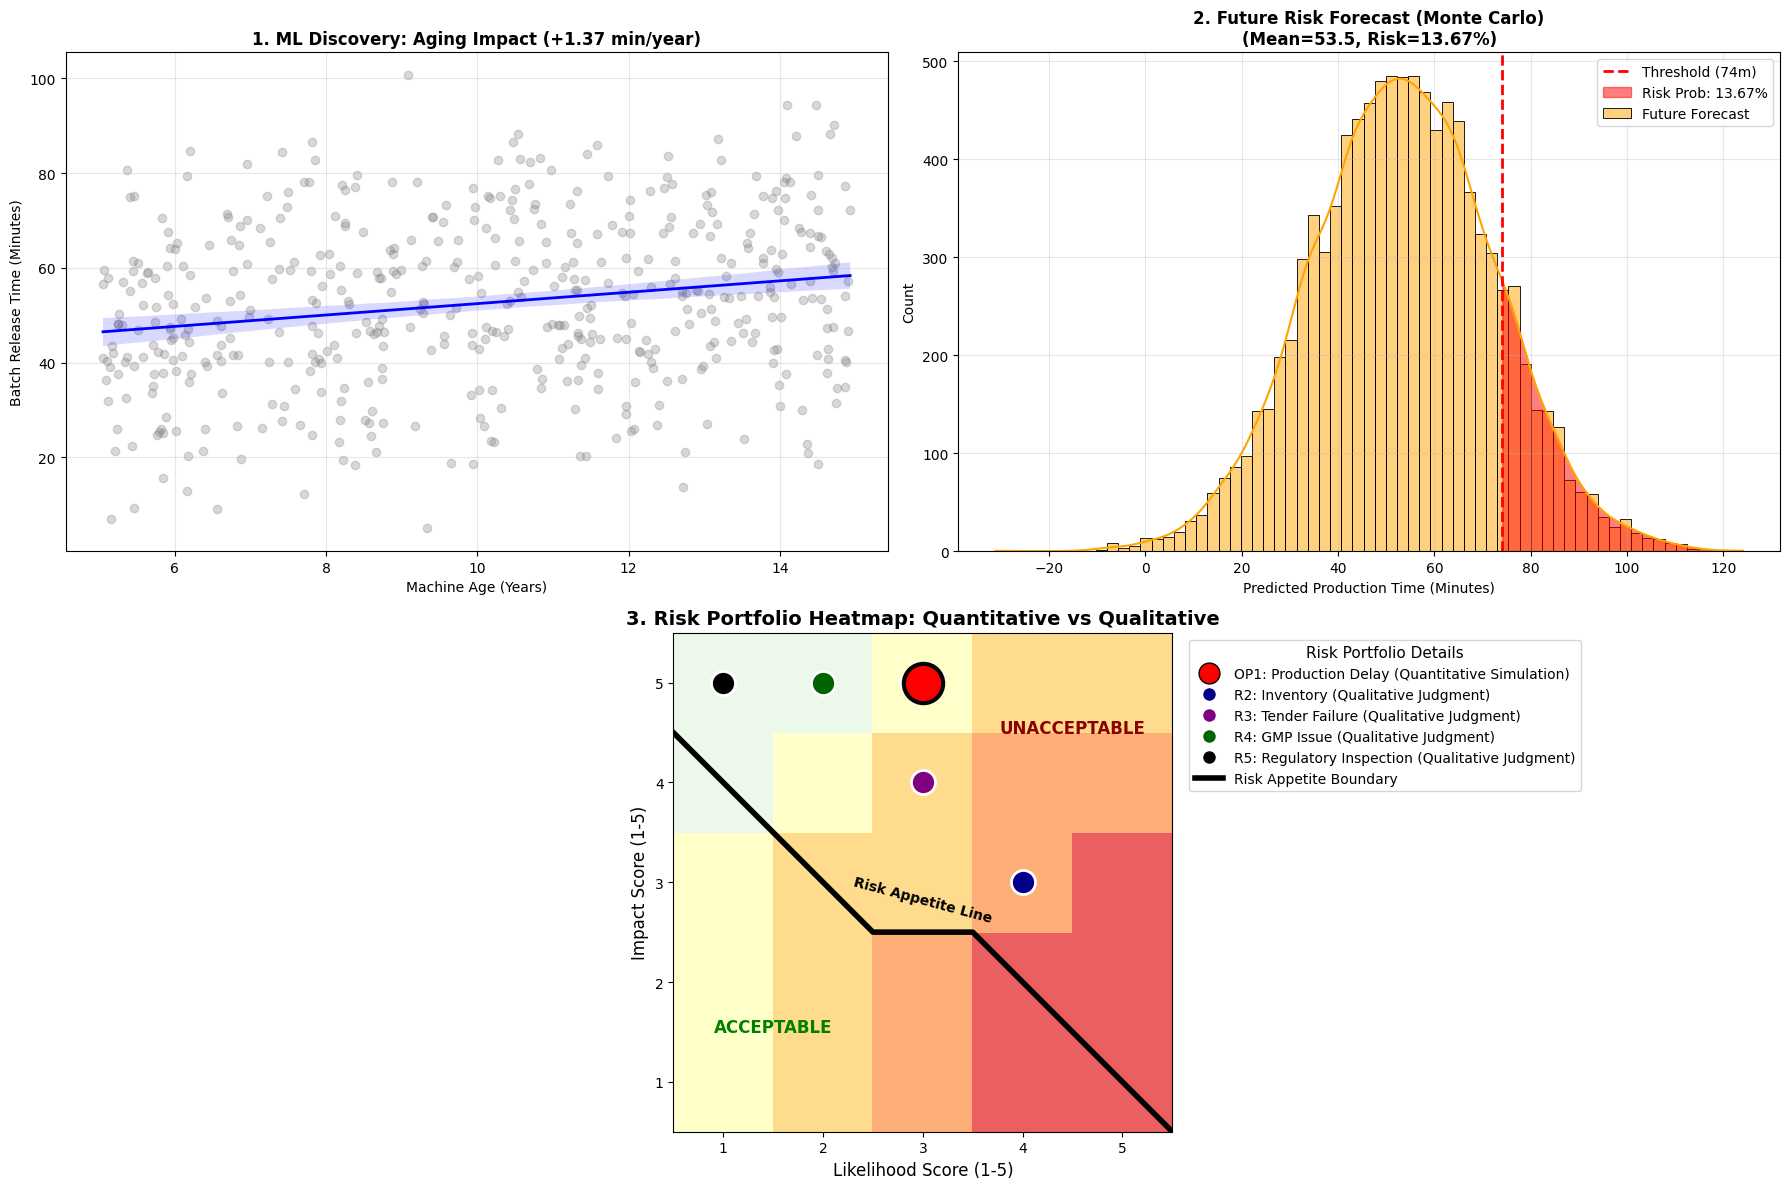

In [37]:
# create canvas
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# --- PLOT 1: ML DISCOVERY (Regression) ---
ax1 = fig.add_subplot(gs[0, 0])
# Plot a subset of data for clarity
sns.regplot(x='Machine_Age', y='Production_Time', data=df_history[:500], ax=ax1,
            scatter_kws={'alpha':0.3, 'color':'gray'}, line_kws={'color':'blue', 'linewidth':2})
ax1.set_title(f'1. ML Discovery: Aging Impact (+{LEARNED_AGE_COEF:.2f} min/year)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Machine Age (Years)')
ax1.set_ylabel('Batch Release Time (Minutes)')
ax1.grid(True, alpha=0.3)

# --- PLOT 2: FUTURE RISK FORECAST (Distribution) ---
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(future_time, kde=True, ax=ax2, color='orange', label='Future Forecast')
ax2.axvline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD}m)')
# Shade the Risk Zone
line = ax2.lines[0]
x_d = line.get_xdata()
y_d = line.get_ydata()
ax2.fill_between(x_d, y_d, where=(x_d > THRESHOLD), color='red', alpha=0.5, label=f'Risk Prob: {prob_risk*100:.2f}%')

ax2.set_title(f'2. Future Risk Forecast (Monte Carlo)\n(Mean={pred_mean:.1f}, Risk={prob_risk*100:.2f}%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Production Time (Minutes)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- PLOT 3: MANAGERIAL RISK HEATMAP ---
ax3 = fig.add_subplot(gs[1, :])
# Heatmap Background
risk_matrix = np.zeros((5, 5))
cmap = ListedColormap(['#e5f5e0', '#ffffb2', '#fecc5c', '#fd8d3c', '#e31a1c'])
background = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 4], [1, 2, 2, 3, 4], [0, 1, 2, 3, 3], [0, 0, 1, 2, 2]])
ax3.imshow(background, cmap=cmap, origin='lower', extent=[0.5, 5.5, 0.5, 5.5], alpha=0.7)

# Risk Appetite Line
ax3.plot([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], [4.5, 3.5, 2.5, 2.5, 1.5, 0.5], color='black', linewidth=4, linestyle='-')
ax3.text(3.0, 2.6, "Risk Appetite Line", fontsize=10, fontweight='bold', color='black', rotation=-15, ha='center')

# --- PLOTTING QUALITATIVE RISKS (Context) ---
qualitative_risks = [
    {'code': 'R2', 'L': 4, 'I': 3, 'name': 'Inventory Risk', 'color': '#00008B'},
    {'code': 'R3', 'L': 3, 'I': 4, 'name': 'Tender Failure', 'color': '#800080'},
    {'code': 'R4', 'L': 2, 'I': 5, 'name': 'GMP Issue', 'color': '#006400'},
    {'code': 'R5', 'L': 1, 'I': 5, 'name': 'Inspection', 'color': 'black'}
]

for r in qualitative_risks:
    ax3.scatter(r['L'], r['I'], s=300, c=r['color'], edgecolors='white', linewidth=2, zorder=5)
    ax3.text(r['L'], r['I'], r['code'], fontsize=11, fontweight='bold', color='white', ha='center', va='center')

# --- PLOTTING OP1 (QUANTITATIVE HIGHLIGHT) ---
ax3.scatter(likelihood_score, impact_score, s=800, c='red', edgecolors='black', linewidth=3, zorder=10)
ax3.text(likelihood_score, impact_score, "OP1", fontsize=16, fontweight='bold', color='white', ha='center', va='center')

# --- LEGEND ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='OP1: Production Delay (Quantitative Simulation)',
           markerfacecolor='red', markersize=15, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='R2: Inventory (Qualitative Judgment)',
           markerfacecolor='#00008B', markersize=10, markeredgecolor='white'),
    Line2D([0], [0], marker='o', color='w', label='R3: Tender Failure (Qualitative Judgment)',
           markerfacecolor='#800080', markersize=10, markeredgecolor='white'),
    Line2D([0], [0], marker='o', color='w', label='R4: GMP Issue (Qualitative Judgment)',
           markerfacecolor='#006400', markersize=10, markeredgecolor='white'),
    Line2D([0], [0], marker='o', color='w', label='R5: Regulatory Inspection (Qualitative Judgment)',
           markerfacecolor='black', markersize=10, markeredgecolor='white'),
    Line2D([0], [0], color='black', lw=4, label='Risk Appetite Boundary')
]

ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1),
           frameon=True, fontsize=10, title="Risk Portfolio Details", title_fontsize=11)

# Zone Labels
ax3.text(1.5, 1.5, 'ACCEPTABLE', color='green', fontweight='bold', ha='center', fontsize=12)
ax3.text(4.5, 4.5, 'UNACCEPTABLE', color='darkred', fontweight='bold', ha='center', fontsize=12)

ax3.set_title('3. Risk Portfolio Heatmap: Quantitative vs Qualitative', fontsize=14, fontweight='bold')
ax3.set_xlabel('Likelihood Score (1-5)', fontsize=12)
ax3.set_ylabel('Impact Score (1-5)', fontsize=12)
ax3.set_xticks(range(1, 6)); ax3.set_yticks(range(1, 6))

plt.tight_layout()
plt.show()